In [1]:
import pandas as pd
import json
import numpy as np
import os
import csv

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
main_path = "../data/"

## Load Data

### results containing reccomendations

In [4]:
#result recommender with only purchase as action on eletronics products
res_p = pd.read_json(os.path.join(main_path,"results/predictions-ecommerce-eletronics-p-10kusers.json"))
#result recommender with purchase (main action) and view on eletronics products
res_pv = pd.read_json(os.path.join(main_path, "results/predictions-ecommerce-eletronics-pv-10kusers.json"))
#result recommender with purchase (main action), view and cart as secondary actions on eletronics products
res_pvc = pd.read_json(os.path.join(main_path, "results/predictions-ecommerce-eletronics-pvc-10kusers.json"))

### dataset containing eletronics item interactions

In [6]:
#df_el = pd.read_csv("../datasets/2019-Nov-eletronics.csv")
df_el = pd.read_csv("/home/francesca/Documents/harness-docker-compose-v1/datasets/2019-Nov-eletronics.csv")

In [7]:
items = df_el[["product_id","brand"]].drop_duplicates()

In [8]:
def get_item_name(result,df):
    result_w_info = list()
    for rec in result:
        df_rec = df[df["product_id"]==int(rec["item"])]
        rec["brand"] = df_rec.iloc[0]["brand"]
        result_w_info.append(rec)
    return result_w_info

res_p.loc[:,"result"] = res_p.apply(lambda row: get_item_name(row["result"], items),1)
res_pv.loc[:,"result"] = res_pv.apply(lambda row: get_item_name(row["result"], items),1)
res_pvc.loc[:,"result"] = res_pvc.apply(lambda row: get_item_name(row["result"], items),1)

In [9]:
res_p.head()

,result,user_id
0,"[{'item': '1005103', 'score': 27.6299858093261...",478741761
1,"[{'item': '1004990', 'score': 12.6461887359619...",491693116
2,"[{'item': '1005100', 'score': 9.5614595413208,...",507897148
3,"[{'item': '1005168', 'score': 15.4581785202026...",510670517
4,"[{'item': '1004249', 'score': 9.20953369140625...",512363921


### train sets

In [10]:
cols = ["event_time","event_type","product_id","category_id","category_code","brand",
       "price","user_id"]
train_p = pd.read_csv(os.path.join(main_path,"input_data/2019-Nov-sample-train-eletronics-purch-10kusers.csv"),
                     names = cols)
#train_pv = pd.read_csv(os.path.join(main_path,"input_data/2019-Nov-sample-train-eletronics-purch-view-10kusers.csv"),
#                     names = cols)
#train_pvc = pd.read_csv(os.path.join(main_path,"input_data/2019-Nov-sample-train-eletronics-purch-view-cart-10kusers.csv"),
#                     names = cols)

In [11]:
res_p.head()

,result,user_id
0,"[{'item': '1005103', 'score': 27.6299858093261...",478741761
1,"[{'item': '1004990', 'score': 12.6461887359619...",491693116
2,"[{'item': '1005100', 'score': 9.5614595413208,...",507897148
3,"[{'item': '1005168', 'score': 15.4581785202026...",510670517
4,"[{'item': '1004249', 'score': 9.20953369140625...",512363921


In [12]:
user = 491693116
train_p[train_p["user_id"]==user]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id
11,2019-11-08 12:29:49+00:00,purchase,1005100,2053013555631882655,electronics.smartphone,samsung,138.23,491693116
12,2019-11-09 07:21:22+00:00,purchase,1004903,2053013555631882655,electronics.smartphone,huawei,113.17,491693116
13,2019-11-09 09:50:04+00:00,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,240.26,491693116
14,2019-11-10 12:30:57+00:00,purchase,1005235,2053013555631882655,electronics.smartphone,oppo,437.57,491693116


In [13]:
res_p[res_p["user_id"]==user].iloc[0]["result"]

[{'item': '1004990', 'score': 12.646188735961914, 'brand': 'oppo'},
 {'item': '1005278', 'score': 10.320852279663086, 'brand': 'meizu'},
 {'item': '1004502', 'score': 10.320852279663086, 'brand': 'oppo'},
 {'item': '1005263', 'score': 9.706514358520508, 'brand': 'oppo'}]

In [14]:
res_pv[res_pv["user_id"]==user].iloc[0]["result"]

[{'item': '1004836', 'score': 23.510536193847656, 'brand': 'samsung'},
 {'item': '1005004', 'score': 23.192882537841797, 'brand': 'huawei'},
 {'item': '1005259', 'score': 22.911670684814453, 'brand': 'umi'},
 {'item': '1005205', 'score': 22.631677627563477, 'brand': 'oppo'}]

In [15]:
res_pvc[res_pvc["user_id"]==user].iloc[0]["result"]

[{'item': '1005238', 'score': 38.10474395751953, 'brand': 'oppo'},
 {'item': '1004839', 'score': 35.28776931762695, 'brand': 'oppo'},
 {'item': '1004961', 'score': 35.256404876708984, 'brand': 'oppo'},
 {'item': '1005205', 'score': 32.88294982910156, 'brand': 'oppo'}]

### Test data

In [16]:
test = pd.read_csv(os.path.join(main_path,"input_data/2019-Nov-sample-test-eletronics-purch-10kusers.csv"),
                     names = cols)

## Prepare results

In [17]:
def extract_rec(df_res):
    df_res.loc[:, "result_items"] = df_res.loc[:,"result"].apply(lambda x: [int(i["item"]) for i in x],1)
    df_res.loc[:, "result_scores"] = df_res.loc[:,"result"].apply(lambda x: [i["score"] for i in x],1)
    df_res.loc[:, "result_length"] = df_res.loc[:, "result"].apply(lambda x: len(x))
    return df_res

res_p = extract_rec(res_p)
res_pv = extract_rec(res_pv)
res_pvc = extract_rec(res_pvc)

# Evaluate recommenders

### Consider how many user-product in test set were recommended

In [18]:
print("RECOMMENDER WITH PURCHASE\n")
test_p = test.merge(res_p, on="user_id", how="inner")
rec_prod_p = test_p[test_p.apply(lambda row: row["product_id"] in row["result_items"],1) == True]

print("(Max) Nr. recommended items: {}".format(np.max(test_p["result_length"])))
print("Nr. of users where test item is recommended: {}".format(len(rec_prod_p)))

RECOMMENDER WITH PURCHASE

(Max) Nr. recommended items: 4
Nr. of users where test item is recommended: 1424


In [19]:
print("RECOMMENDER WITH PURCHASE AND VIEW\n")
test_pv = test.merge(res_pv, on="user_id", how="inner")
rec_prod_pv = test_pv[test_pv.apply(lambda row: row["product_id"] in row["result_items"],1) == True]

print("(Max) Nr. recommended items: {}".format(np.max(test_pv["result_length"])))
print("Nr. of users where test item is recommended: {}".format(len(rec_prod_pv)))

RECOMMENDER WITH PURCHASE AND VIEW

(Max) Nr. recommended items: 4
Nr. of users where test item is recommended: 1575


In [20]:
print("RECOMMENDER WITH PURCHASE, VIEW AND CART\n")
test_pvc = test.merge(res_pvc, on="user_id", how="inner")
rec_prod_pvc = test_pvc[test_pvc.apply(lambda row: row["product_id"] in row["result_items"],1) == True]

print("(Max) Nr. recommended items: {}".format(np.max(test_pvc["result_length"])))
print("Nr. of users where test item is recommended: {}".format(len(rec_prod_pvc)))

RECOMMENDER WITH PURCHASE, VIEW AND CART

(Max) Nr. recommended items: 4
Nr. of users where test item is recommended: 1620


## Intersections between recommenders

In [55]:
print(
    "Percentage of users in pvc recommender that are in pv recommender: {}\n".format(
    len(rec_prod_pvc[rec_prod_pvc["user_id"].isin(rec_prod_pv["user_id"].unique())])*100/len(rec_prod_pvc)
)
    )

print(
    "Percentage of users in pvc recommender that are in p recommender: {}\n".format(
    len(rec_prod_pvc[rec_prod_pvc["user_id"].isin(rec_prod_p["user_id"].unique())])*100/len(rec_prod_pvc)
)
    )


print(
    "Percentage of users in pv recommender that are in p recommender: {}\n".format(
    len(rec_prod_pv[rec_prod_pv["user_id"].isin(rec_prod_p["user_id"].unique())])*100/len(rec_prod_pv)
)
    )

Percentage of users in pvc recommender that are in pv recommender: 62.098765432098766

Percentage of users in pvc recommender that are in p recommender: 44.19753086419753

Percentage of users in pv recommender that are in p recommender: 43.04761904761905



### Item positions in recommendations

In [56]:
def find_position(scores, items, product_id):
    prod_index = items.index(product_id)
    return prod_index

rec_prod_p.loc[:,"item_position"] = rec_prod_p.apply(lambda row: find_position(row["result_scores"],
                                                                            row["result_items"],
                                                                            row["product_id"]), axis=1)

rec_prod_pv.loc[:,"item_position"] = rec_prod_pv.apply(lambda row: find_position(row["result_scores"],
                                                                            row["result_items"],
                                                                            row["product_id"]), axis=1)

rec_prod_pvc.loc[:,"item_position"] = rec_prod_pvc.apply(lambda row: find_position(row["result_scores"],
                                                                            row["result_items"],
                                                                            row["product_id"]), axis=1)


/home/francesca/anaconda3/envs/universal-rec/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/francesca/anaconda3/envs/universal-rec/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


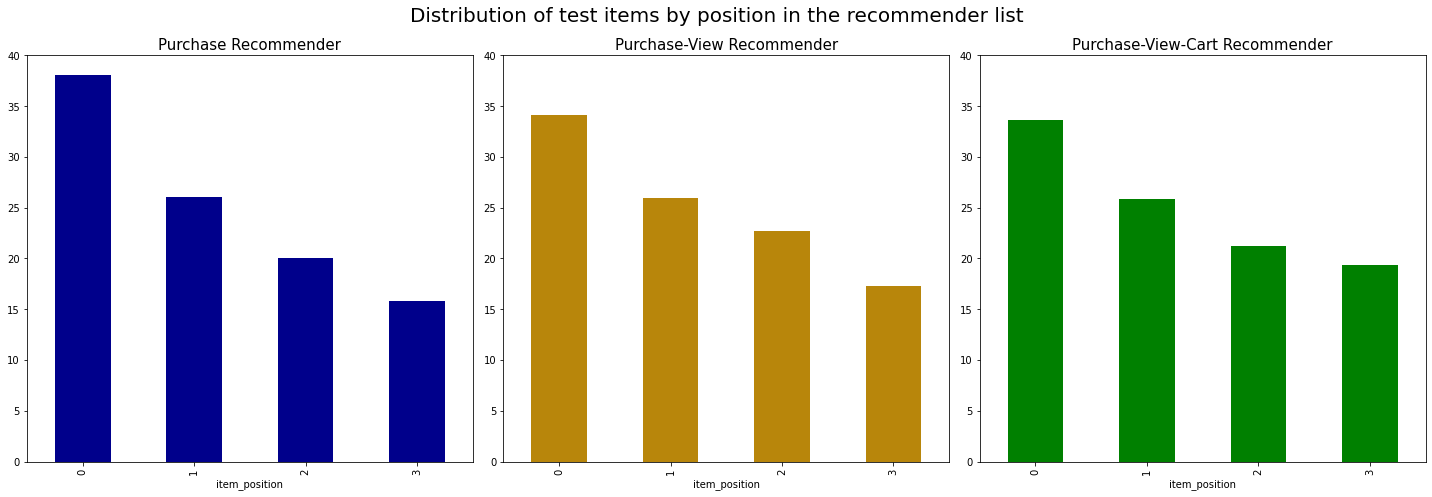

In [86]:
fig = plt.figure(figsize=(20,7))
fig.suptitle("Distribution of test items by position in the recommender list", fontsize=20)
plt.subplot(131)
(rec_prod_p.groupby("item_position").size()*100/len(rec_prod_p)).plot(kind="bar", 
                                                                      color='darkblue')
plt.ylim(0,40)
plt.title("Purchase Recommender", fontsize=15)
plt.subplot(132)
(rec_prod_pv.groupby("item_position").size()*100/len(rec_prod_pv)).plot(kind="bar",
                                                                       color='darkgoldenrod')
plt.ylim(0,40)
plt.title("Purchase-View Recommender", fontsize=15)

plt.subplot(133)
(rec_prod_pvc.groupby("item_position").size()*100/len(rec_prod_pvc)).plot(kind="bar",
                                                                         color='green')
plt.title("Purchase-View-Cart Recommender", fontsize=15)
plt.ylim(0,40)

plt.tight_layout()
plt.show()